# 2. Image Generation using Reverse Engineering

User's expectation

<img src="./img-sample-car-interior.jpg" alt="luxury car interior" width="600"/>


Prompt

```
Interior of a luxury car with white seat and screen on the back of the front seat.
```

<img src="./img-dalle3-car-interior.jpg" alt="dalle3 luxury car interior" width="600"/>

## Reverse Engineering Prompt

In [40]:
import os
from dotenv import load_dotenv
load_dotenv()

# GPT-4o
api_endpoint = os.environ['AZURE_OPENAI_ENDPOINT']
api_key=os.environ['AZURE_OPENAI_KEY']

In [4]:
# GPT-4o endpoint and key
from openai import AzureOpenAI

client = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=api_endpoint,
    api_version="2024-02-01"
)

In [31]:
def chat_gpt(messages):

    response = client.chat.completions.create(
        messages=messages,
        model="gpt-4o", 
        response_format={"type": "json_object"},
        temperature=0.0,
        seed=99999)

    return response

In [28]:
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"



In [77]:
system_message = """You are a helpful assistant designed to output JSON."""

def img_caption(image_path):
    prompt = "describe this picture and generate dalle prompt for generating similar to this image"

    data_url = local_image_to_data_url(image_path)
    message_history = []
    message_history.append({"role": "system", "content": system_message})
    message_history.append({"role": "user", "content": [
        {
            "type": "text",
            "text": prompt
        },
        {
            "type": "image_url",
            "image_url": {
                "url": data_url
            }
        }]}
    )

    response = chat_gpt(message_history)

    return response.choices[0].message.content

In [78]:
image_path = "./img-sample-car-interior.jpg"
response = img_caption(image_path)
response

'{\n  "description": "The image shows the luxurious interior of a high-end car. The seats are upholstered in white leather with brown accents. The back of the front seats features built-in screens for rear passengers. The center console has various controls and a sleek design. The car has a panoramic sunroof, allowing natural light to fill the cabin. The windows provide a view of the outside, where a few people are standing near other cars.",\n  "dalle_prompt": "luxurious car interior with white leather seats and brown accents, built-in screens on the back of the front seats, panoramic sunroof, sleek center console with controls, natural light filling the cabin"\n}'

In [68]:
import textwrap

def print_wrapped(response):
    text = response
    text = text.replace('\n', '<newline>')
    wrapped_text = textwrap.fill(text, width=120)
    wrapped_text = wrapped_text.replace('<newline>', '\n')
    print(wrapped_text)

In [79]:
print_wrapped(response)

{
  "description": "The image shows the luxurious interior of a high-end car. The seats are upholstered in white
leather with brown accents. The back of the front seats features built-in screens for rear passengers. The center
console has various controls and a sleek design. The car has a panoramic sunroof, allowing natural light to fill the
cabin. The windows provide a view of the outside, where a few people are standing near other cars.",

"dalle_prompt": "luxurious car interior with white leather seats and brown accents, built-in screens on the back of the
front seats, panoramic sunroof, sleek center console with controls, natural light filling the cabin"
}


In [70]:
import json

js = json.loads(response)
dalle_prompt = js["dalle_prompt"]

In [71]:
dalle_prompt

'A luxurious car interior with white leather seats and brown accents, screens mounted on the back of the front seats, a center console with controls and a small display, and a panoramic sunroof. The windows show an outside view.'

In [80]:
dalle_prompt = "Interior of a luxury car with white leather seats and diamond stitching, brown leather accents, entertainment screens on the back of the front seats, panoramic sunroof, and a center console with various controls. The dashboard and steering wheel are visible, and the windows show people outside the vehicle"

## Image Generation

In [72]:
# azure openai region for dall-e model
client_dalle = AzureOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    api_version="2024-02-01",
    azure_endpoint = os.environ['AZURE_OPENAI_ENDPOINT']
)

In [55]:
from io import BytesIO
from IPython.display import display
from PIL import Image as PILImage

import requests

def get_image(url):
    response = requests.get(url)
    image = PILImage.open(BytesIO(response.content))

    return image

In [85]:
def img_generation(dalle_prompt, quality="hd", style="natural"):
    response = client_dalle.images.generate(
        model=os.environ['AZURE_OPENAI_DALLE_MODEL'],
        prompt=dalle_prompt,
        size="1024x1024",
        quality=quality,
        style=style,
        n=1,
    )

    return response.data[0]

In [87]:
response = img_generation(dalle_prompt)

In [88]:
url = response.url
revised_prompt = response.revised_prompt

A luxurious car interior showcasing immaculate white leather seats detailed with diamond stitching, complemented by
brown leather accents. Entertainment screens are mounted at the back of the front seats, ensuring passenger
entertainment during transit. Above, a sizeable panoramic sunroof brightens the interior, bridging the gap between
inside and outside. The center console is elaborated with an array of various controls, suggesting a highly-tech
equipped vehicle. Visibility to the dashboard and steering wheel is clear, both exhibiting high-end craftsmanship.
Through the car windows, varying individuals of different descents and genders can be seen, adding a lively ambiance to
the otherwise inactive vehicle.


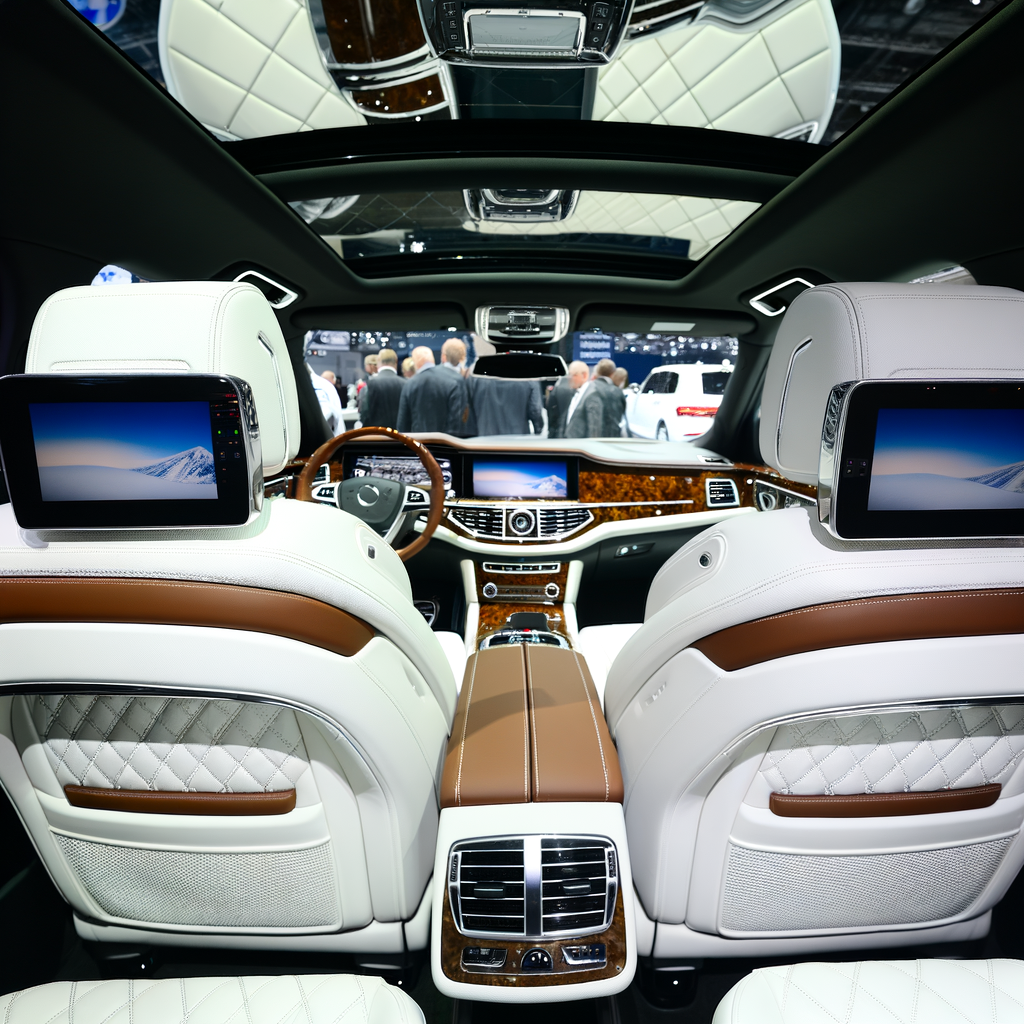

In [89]:
print_wrapped(revised_prompt)
img = get_image(url)
display(img)

# save to file
img.save("dalle3-car-interior.jpg")

In [91]:
dalle_prompt = """Side interior view of A luxurious car showcasing immaculate white leather seats detailed with diamond stitching, complemented by brown leather accents. 
Entertainment screens are mounted at the back of the front seats, ensuring passenger entertainment during transit. 
Above, a sizeable panoramic sunroof. The center console is elaborated with an array of various controls, suggesting a highly-tech equipped vehicle. 
Visibility to the dashboard and steering wheel is clear, both exhibiting high-end craftsmanship.
Through the car windows, varying individuals of different descents and genders can be seen, adding a lively ambiance to the otherwise inactive vehicle.
"""

Showcase an interior side view of a luxury car. The car contains immaculate white leather seats detailed with diamond
stitching, which are complemented by brown leather accents. Entertainment screens are mounted at the back of the front
seats, providing passengers a source of distraction during transit. Above, a considerable panoramic sunroof allows light
to stream into the car. The center console is covered with a variety of controls, implying a tech-savvy vehicle. The
dashboard and steering wheel are visible, each demonstrating fine craftsmanship. Outside the car windows, various
individuals from diverse descents such as Caucasian, Hispanic, Black, Middle-Eastern, and South Asian, and a mix of men
and women can be seen, providing a lively ambiance to the stationary vehicle.


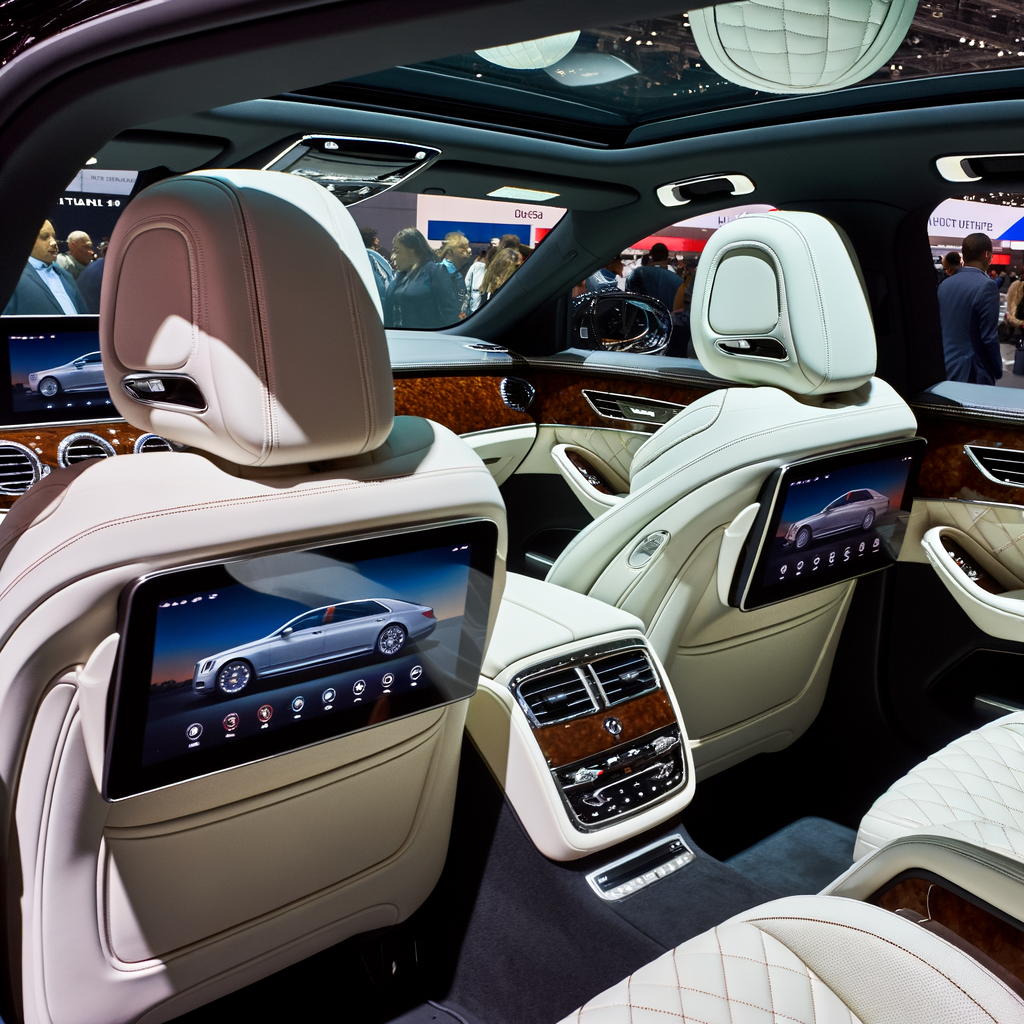

In [92]:
response = img_generation(dalle_prompt)
url = response.url
revised_prompt = response.revised_prompt
print_wrapped(revised_prompt)
img = get_image(url)
display(img)


In [93]:
# save to file
img.save("dalle3-car-interior2.jpg")